In [9]:
!pip install transformers torch
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
from torch.nn.functional import softmax


In [10]:
df = pd.read_csv('/CombinedForums.csv')

In [11]:
import numpy as np

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # This BERT model is trained for sentiment analysis.
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [14]:
def predict_sentiments(texts, batch_size):
    sentiments = []
    model.to(device)  # Ensure model is on the correct device

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=1)
        sentiments.extend(preds.cpu().numpy())
    return sentiments

In [20]:
df['Comment'] = df['Comment'].astype(str)
batch_size = 32
df['sentiment'] = predict_sentiments(df['Comment'].tolist(), batch_size)

In [21]:
df.to_csv('dataset_with_sentiments.csv', index=False)

In [22]:
df

,Name,Comment,Date,Model,sentiment
0,Mazda 3s,After months of releasing preview images and s...,"August 29, 2022",Maserati Grecale,3
1,Darepoole,It looks like the Macan with a little bit of I...,"March 22, 2022",Maserati Grecale,2
2,JackStraw79,Nice hot hatch!,"March 22, 2022",Maserati Grecale,4
3,CostcoPizza,"Looks like a car you'd find in GTA V DLC, whic...","March 22, 2022",Maserati Grecale,3
4,Venom21,Terrible gloss black: CheckTerrible touchscree...,"March 22, 2022",Maserati Grecale,0
...,...,...,...,...,...
49370,Wing Commander,I suppose we should be grateful that at least ...,"October 02, 2021",Porsche Macan,4
49371,sd1985,Our first macan was a base on 21s with no Pasm...,"October 02, 2021",Porsche Macan,2
49372,BanZ,"For gen3, on the uk configurator PASM is not c...","October 02, 2021",Porsche Macan,3
49373,Col Lamb,Well that is another reason for avoiding the 2...,"October 02, 2021",Porsche Macan,0


In [23]:
df_with_sentiments = df.copy()

In [24]:
df_with_sentiments.to_csv('dataset_with_sentiments.csv', index=False)

In [25]:
# List of car models to filter by
car_models = ['Maserati Grecale', 'Alfa Romeo Stelvio', 'BMW X3', 'Audi Q5', 'Porsche Macan']

# Filter dataset by the car models
filtered_df = df_with_sentiments[df_with_sentiments['Model'].isin(car_models)]

# Group by 'Car Model' and 'sentiment' and count
grouped = filtered_df.groupby(['Model', 'sentiment']).size().reset_index(name='Count')

print(grouped)


                 Model  sentiment  Count
0   Alfa Romeo Stelvio          0   1597
1   Alfa Romeo Stelvio          1   1550
2   Alfa Romeo Stelvio          2   2551
3   Alfa Romeo Stelvio          3   1433
4   Alfa Romeo Stelvio          4   1326
5              Audi Q5          0   2199
6              Audi Q5          1   1785
7              Audi Q5          2   2743
8              Audi Q5          3   1645
9              Audi Q5          4   1626
10              BMW X3          0   2420
11              BMW X3          1   2251
12              BMW X3          2   3086
13              BMW X3          3   2147
14              BMW X3          4   2129
15    Maserati Grecale          0    188
16    Maserati Grecale          1    185
17    Maserati Grecale          2    216
18    Maserati Grecale          3    150
19    Maserati Grecale          4    148
20       Porsche Macan          0   3341
21       Porsche Macan          1   3335
22       Porsche Macan          2   5122
23       Porsche

In [ ]:
from torch.utils.data import Dataset

In [ ]:
# Constants
batch_size = 16
max_sequence_length = 256
epochs = 3
learning_rate = 2e-5

In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
# Dataset definition with adjustments
class SentimentDataset(Dataset):
    def __init__(self, tokenizer, comments, labels, max_len):
        self.tokenizer = tokenizer
        self.comments = comments
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# First, split the original df_with_sentiments into train and test
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df_with_sentiments, test_size=0.3, random_state=42)

In [ ]:
train_data = SentimentDataset(tokenizer, train_df['Comment'].tolist(), train_df['sentiment'].tolist(), max_sequence_length)
test_data = SentimentDataset(tokenizer, test_df['Comment'].tolist(), test_df['sentiment'].tolist(), max_sequence_length)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Define the training function
def train_epoch(model, data_loader, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Define the evaluation function
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Train the model
n_epochs = 3
for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, len(train_df))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    test_acc, test_loss = eval_model(model, test_loader, device, len(test_df))
    print(f'Test loss {test_loss} accuracy {test_acc}')
    print()

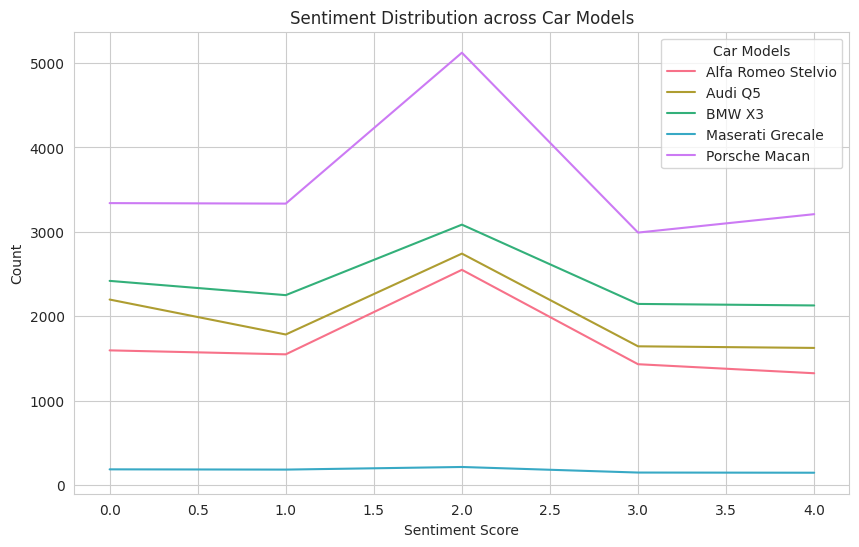

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("husl", len(car_models))

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='sentiment', y='Count', hue='Model', palette=palette)

# Set the title and labels
plt.title('Sentiment Distribution across Car Models')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(title='Car Models')

plt.show()


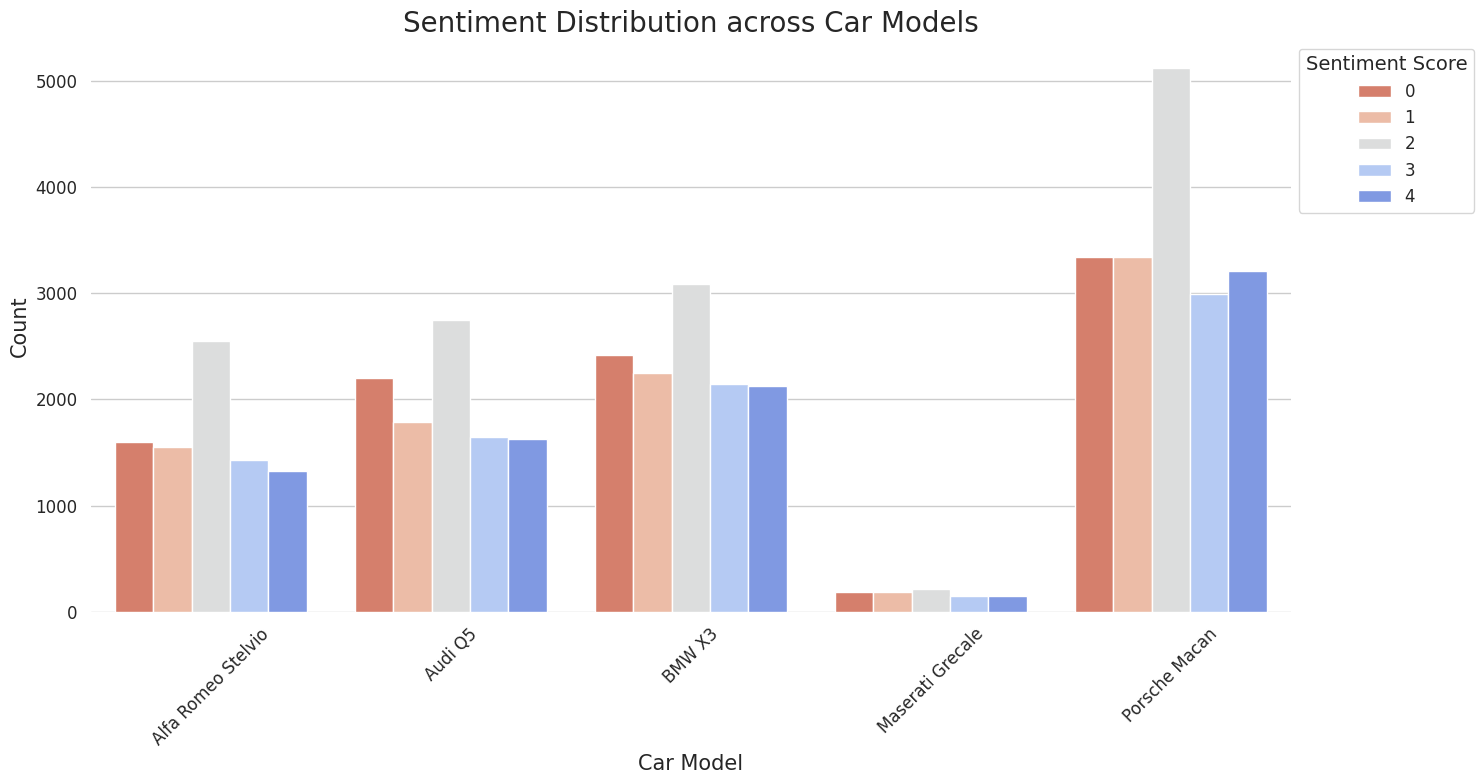

In [27]:
# Set theme and style
sns.set_theme(style="whitegrid")

# Set up a larger figure
plt.figure(figsize=(15, 8))

# Create a palette to visually differentiate sentiments
palette = sns.color_palette("coolwarm_r", 5)

# Grouped bar chart
chart = sns.barplot(data=grouped, x='Model', y='Count', hue='sentiment', palette=palette)

# Set the title and labels
plt.title('Sentiment Distribution across Car Models', fontsize=20)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Remove the borders for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.tight_layout()
plt.show()


<ipython-input-28-24fe04630ff5>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)


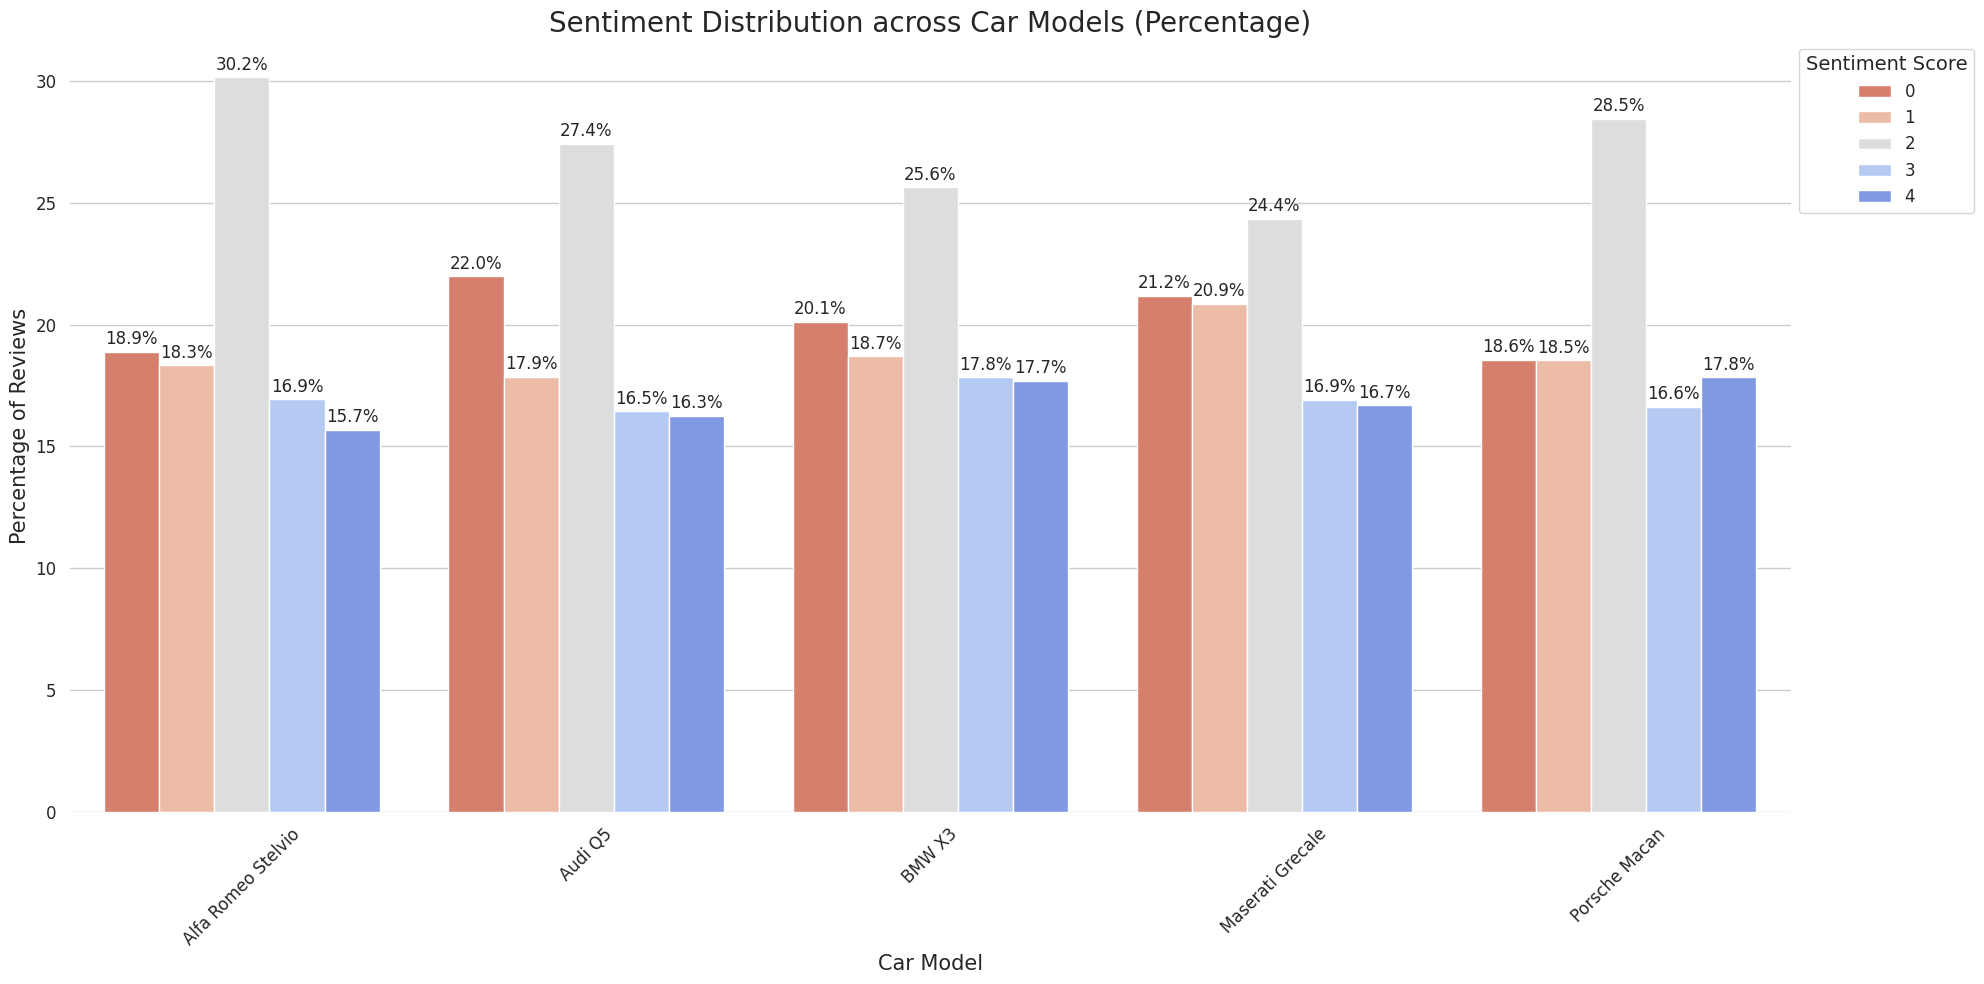

In [28]:
# Compute percentage for each sentiment score within each car model
grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)

import seaborn as sns
import matplotlib.pyplot as plt

# Set theme and style
sns.set_theme(style="whitegrid")

# Set up a larger figure
plt.figure(figsize=(20, 10))

# Create a palette to visually differentiate sentiments
palette = sns.color_palette("coolwarm_r", 5)

# Grouped bar chart
chart = sns.barplot(data=grouped, x='Model', y='Percentage', hue='sentiment', palette=palette)

# Annotating each bar with the respective percentage
for p in chart.patches:
    chart.annotate(f'{p.get_height():.1f}%',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

# Set the title and labels
plt.title('Sentiment Distribution across Car Models (Percentage)', fontsize=20)
plt.ylabel('Percentage of Reviews', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Remove the borders for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.tight_layout()
plt.show()


<ipython-input-29-4927bc701056>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)


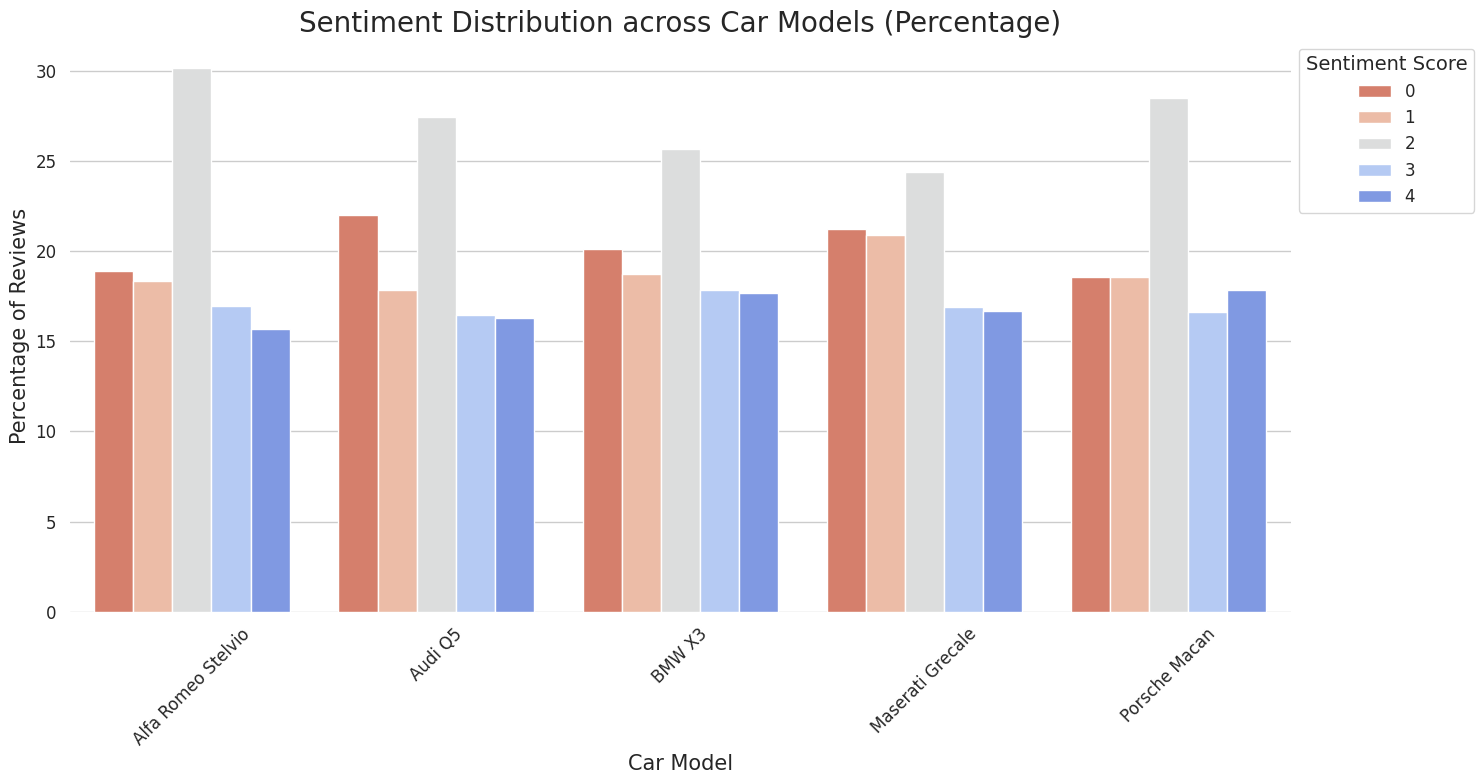

In [29]:
# Compute percentage for each sentiment score within each car model
grouped['Percentage'] = grouped.groupby('Model')['Count'].apply(lambda x: x / x.sum() * 100)

import seaborn as sns
import matplotlib.pyplot as plt

# Set theme and style
sns.set_theme(style="whitegrid")

# Set up a larger figure
plt.figure(figsize=(15, 8))

# Create a palette to visually differentiate sentiments
palette = sns.color_palette("coolwarm_r", 5)

# Grouped bar chart
chart = sns.barplot(data=grouped, x='Model', y='Percentage', hue='sentiment', palette=palette)

# Set the title and labels
plt.title('Sentiment Distribution across Car Models (Percentage)', fontsize=20)
plt.ylabel('Percentage of Reviews', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Remove the borders for a cleaner look
sns.despine(left=True, bottom=True)

# Display the plot
plt.tight_layout()
plt.show()

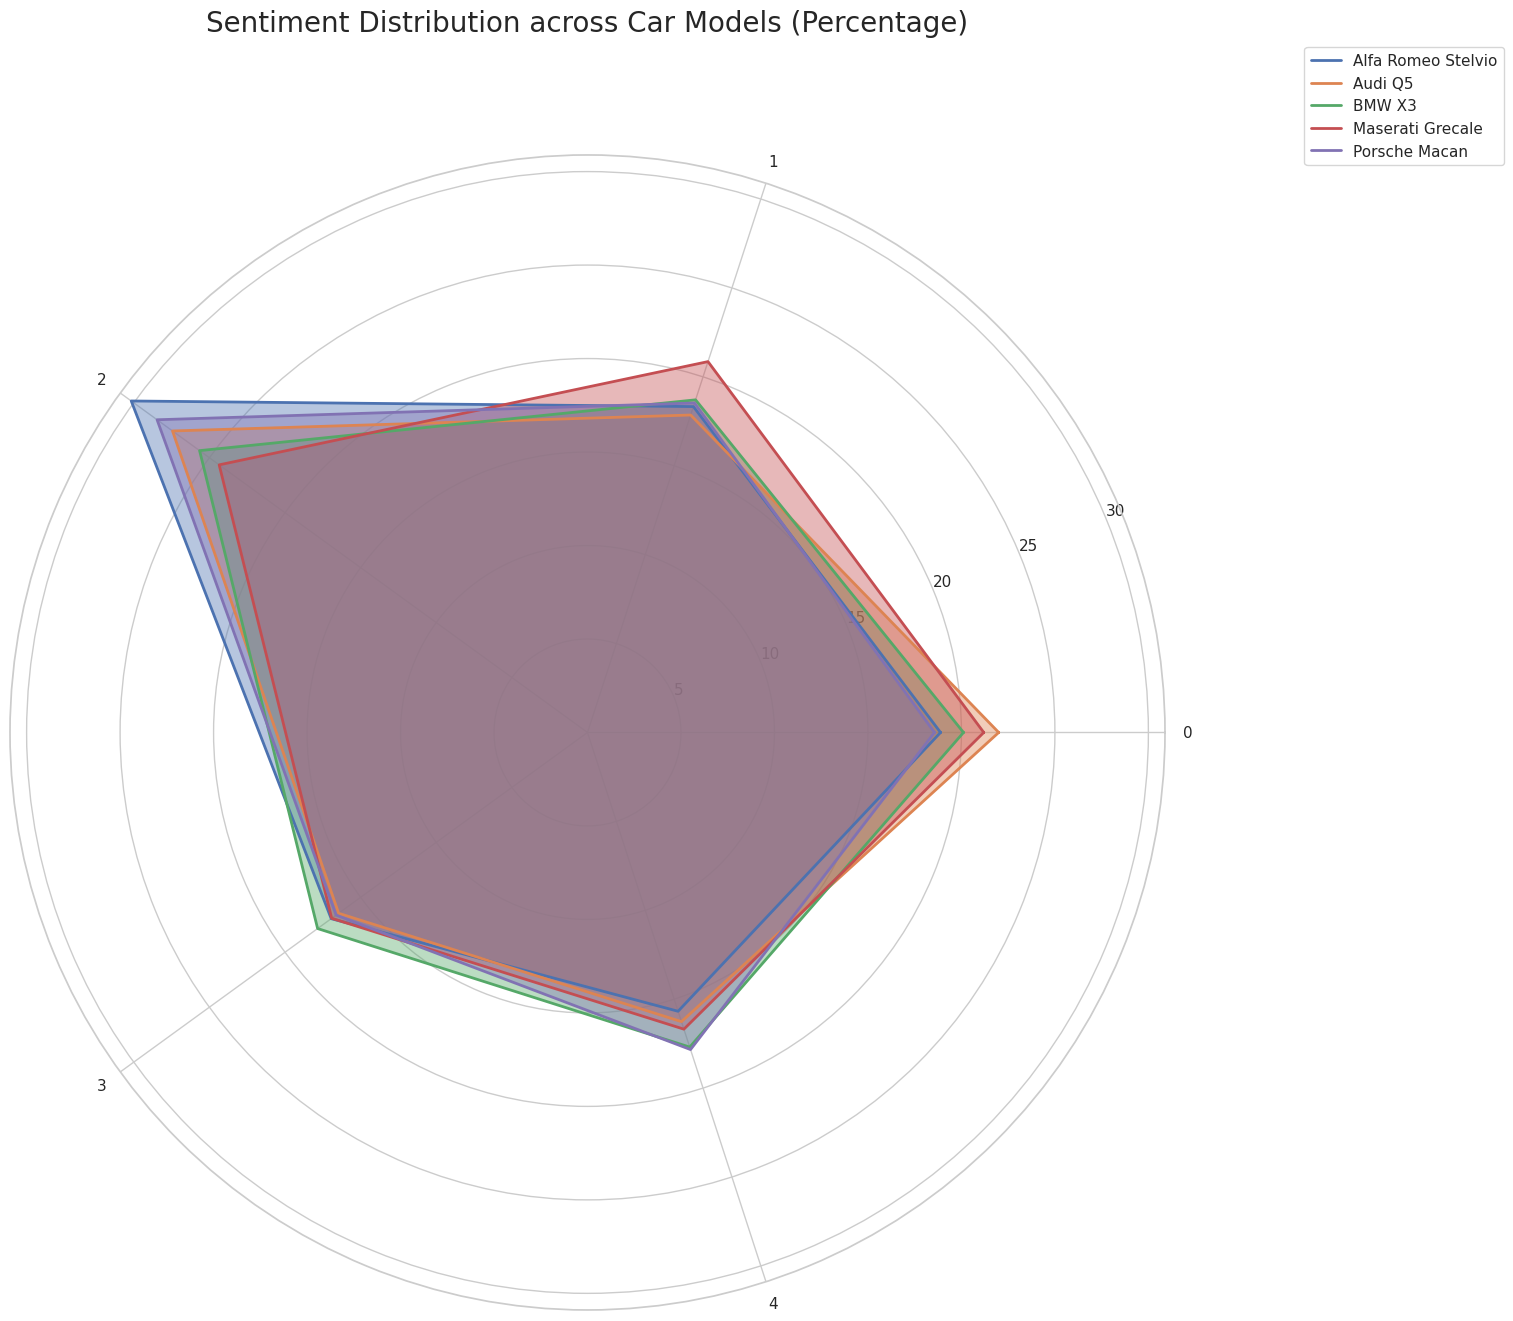

In [30]:
import numpy as np

# Number of variables (sentiments)
categories = grouped['sentiment'].unique()
N = len(categories)

# Set data
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(15, 15))
ax = plt.subplot(111, polar=True)

# Draw one axe per sentiment score with labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Plot data and fill with color for each car model
for i, model in enumerate(grouped['Model'].unique()):
    values = grouped[grouped['Model'] == model]['Percentage'].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.4)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Sentiment Distribution across Car Models (Percentage)', y=1.1, fontsize=20)
plt.show()


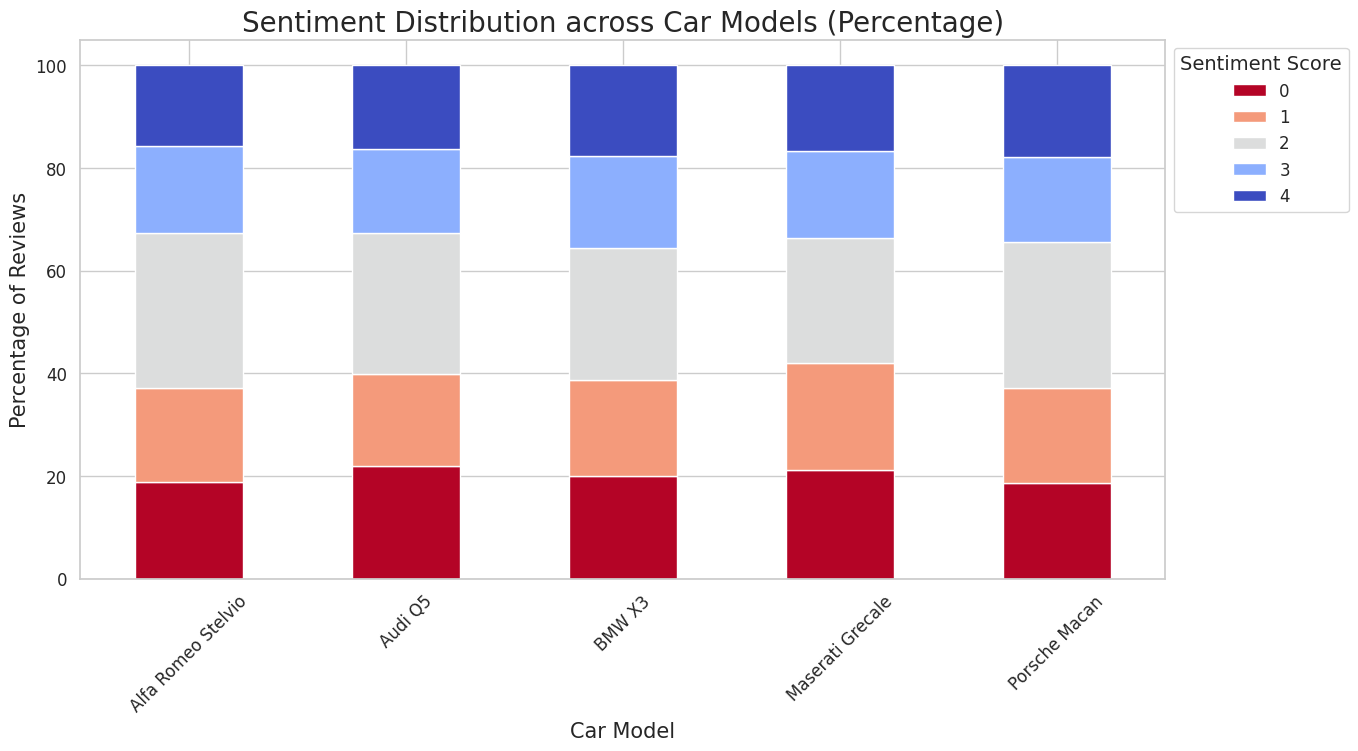

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot the data for stacked bar chart
pivot_df = grouped.pivot(index='Model', columns='sentiment', values='Percentage')

# Plot
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14,7), colormap="coolwarm_r")
plt.title('Sentiment Distribution across Car Models (Percentage)', fontsize=20)
plt.ylabel('Percentage of Reviews', fontsize=15)
plt.xlabel('Car Model', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment Score', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


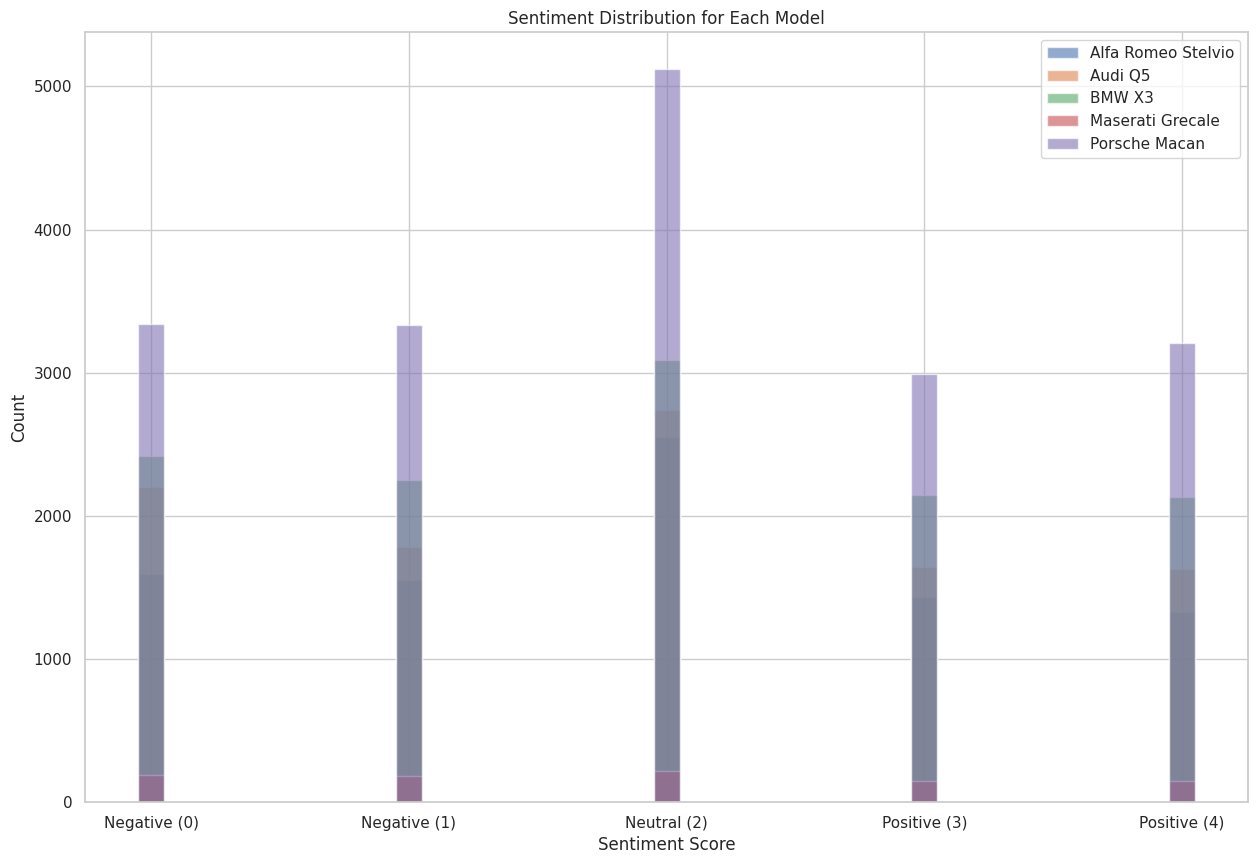

In [32]:
import matplotlib.pyplot as plt

# Convert the extracted sentiment results into a DataFrame
sentiment_data = {
    "Model": ["Alfa Romeo Stelvio", "Alfa Romeo Stelvio", "Alfa Romeo Stelvio", "Alfa Romeo Stelvio", "Alfa Romeo Stelvio",
              "Audi Q5", "Audi Q5", "Audi Q5", "Audi Q5", "Audi Q5",
              "BMW X3", "BMW X3", "BMW X3", "BMW X3", "BMW X3",
              "Maserati Grecale", "Maserati Grecale", "Maserati Grecale", "Maserati Grecale", "Maserati Grecale",
              "Porsche Macan", "Porsche Macan", "Porsche Macan", "Porsche Macan", "Porsche Macan"],
    "Sentiment Score": [0, 1, 2, 3, 4]*5,
    "Count": [1597, 1550, 2551, 1433, 1326,
              2199, 1785, 2743, 1645, 1626,
              2420, 2251, 3086, 2147, 2129,
              188, 185, 216, 150, 148,
              3341, 3335, 5122, 2992, 3210]
}

sentiment_df = pd.DataFrame(sentiment_data)

# Plotting the sentiment distribution
plt.figure(figsize=(15, 10))
for model in sentiment_df['Model'].unique():
    subset = sentiment_df[sentiment_df['Model'] == model]
    plt.bar(subset['Sentiment Score'], subset['Count'], label=model, alpha=0.6, width=0.1)

plt.title("Sentiment Distribution for Each Model")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Negative (0)", "Negative (1)", "Neutral (2)", "Positive (3)", "Positive (4)"])
plt.legend()
plt.show()


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract the top keywords for each car model using TF-IDF
def extract_top_keywords(model_name, n_keywords=10):
    comments = df[df['Model'] == model_name]['Comment'].dropna()

    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(comments)

    # Get feature names and sort them based on importance
    feature_names = vectorizer.get_feature_names_out()
    sorted_items = sorted(list(zip(feature_names, sum(tfidf_matrix.toarray()))), key=lambda x: x[1], reverse=True)

    # Get the top keywords
    keywords = [item[0] for item in sorted_items[:n_keywords]]
    return keywords

top_keywords = {}
for model_name in df['Model'].unique():
    top_keywords[model_name] = extract_top_keywords(model_name)

top_keywords


{'Maserati Grecale': ['car',
  'grecale',
  'maserati',
  'like',
  'just',
  'dealer',
  'new',
  'good',
  'modena',
  'issues'],
 'Alfa Romeo Stelvio': ['stelvio',
  'car',
  'just',
  'alfa',
  'like',
  'giulia',
  'think',
  've',
  'new',
  'good'],
 'BMW X3': ['x3',
  'car',
  'bmw',
  'just',
  'thanks',
  'like',
  'm40i',
  'dealer',
  'new',
  'don'],
 'Audi Q5': ['car',
  'audi',
  'just',
  'q5',
  'new',
  'sq5',
  'thanks',
  'good',
  'dealer',
  'like'],
 'Porsche Macan': ['car',
  'just',
  'nan',
  'macan',
  'porsche',
  'like',
  'good',
  'think',
  've',
  'gts']}